# NASA Turbofan Jet Engine Predictive Maintenance

## Installing and Importing Libraries

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [147]:
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score, mean_squared_error

## Reading Data

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# /content/drive/MyDrive/Colab Notebooks/NasaTurbofan

Mounted at /content/drive


In [117]:
dir_path = './dataset/CMaps/'

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

train1 = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
train2 = pd.read_csv((dir_path+'train_FD002.txt'), sep='\s+', header=None, names=col_names)
train3 = pd.read_csv((dir_path+'train_FD003.txt'), sep='\s+', header=None, names=col_names)
train4 = pd.read_csv((dir_path+'train_FD004.txt'), sep='\s+', header=None, names=col_names)

test1 = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
test2 = pd.read_csv((dir_path+'test_FD002.txt'), sep='\s+', header=None, names=col_names)
test3 = pd.read_csv((dir_path+'test_FD003.txt'), sep='\s+', header=None, names=col_names)
test4 = pd.read_csv((dir_path+'test_FD004.txt'), sep='\s+', header=None, names=col_names)

y_test1 = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])
y_test2 = pd.read_csv((dir_path+'RUL_FD002.txt'), sep='\s+', header=None, names=['RUL'])
y_test3 = pd.read_csv((dir_path+'RUL_FD003.txt'), sep='\s+', header=None, names=['RUL'])
y_test4 = pd.read_csv((dir_path+'RUL_FD004.txt'), sep='\s+', header=None, names=['RUL'])

## Adding RUL to the training data
RUL = max_cycle - time_cycles

In [118]:
def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [119]:
train1 = add_remaining_useful_life(train1)
train1[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  191
1        1            2  190
2        1            3  189
3        1            4  188
4        1            5  187

In [120]:
train2 = add_remaining_useful_life(train2)
train2[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  148
1        1            2  147
2        1            3  146
3        1            4  145
4        1            5  144

In [121]:
train3 = add_remaining_useful_life(train3)
train3[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  258
1        1            2  257
2        1            3  256
3        1            4  255
4        1            5  254

In [122]:
train4 = add_remaining_useful_life(train4)
train4[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  320
1        1            2  319
2        1            3  318
3        1            4  317
4        1            5  316

## Exploratory Data Analysis

### RUL Frequency Histogram

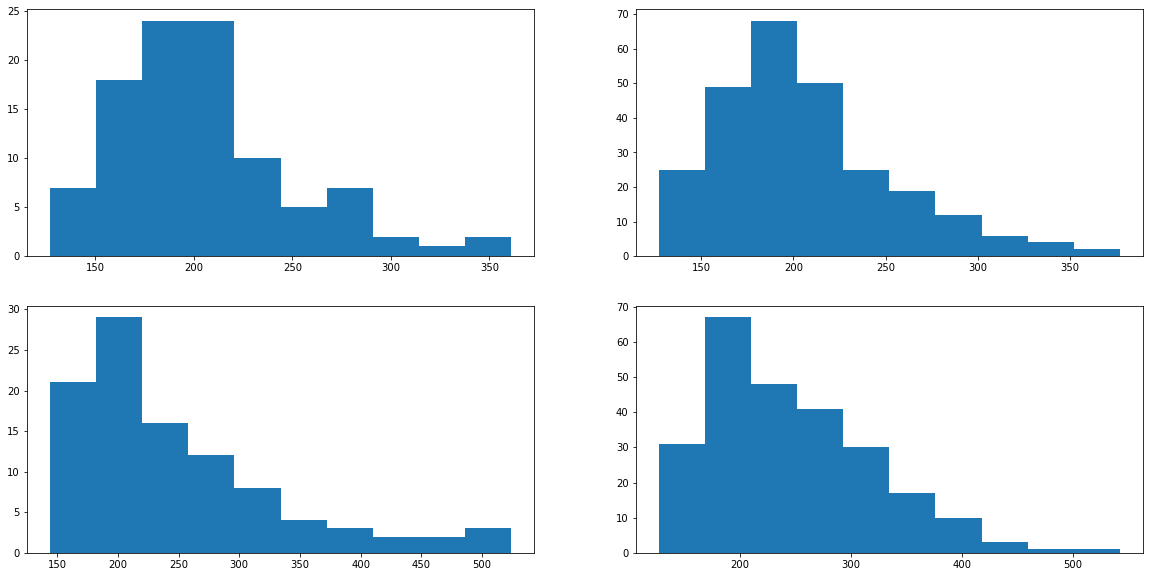

In [9]:
fig,axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()

data = [train1, train2, train3, train4]

for i,ax in enumerate(axs):
  df_max_rul = data[i][['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
  ax.hist(df_max_rul['RUL'])

### RUL per sensor

In [10]:
def plot_sensor(sensor_name, data, axs):
  for i in data['unit_nr'].unique():
      if (i % 10 == 0):  # only plot every 10th unit_nr
          axs.plot('RUL', sensor_name, data=data[data['unit_nr']==i])
  axs.set(title=sensor_name, xlabel='Remaining Useful Life', ylabel='unit_nr', xlim=(250,0), xticks=np.arange(0, 275, 25))

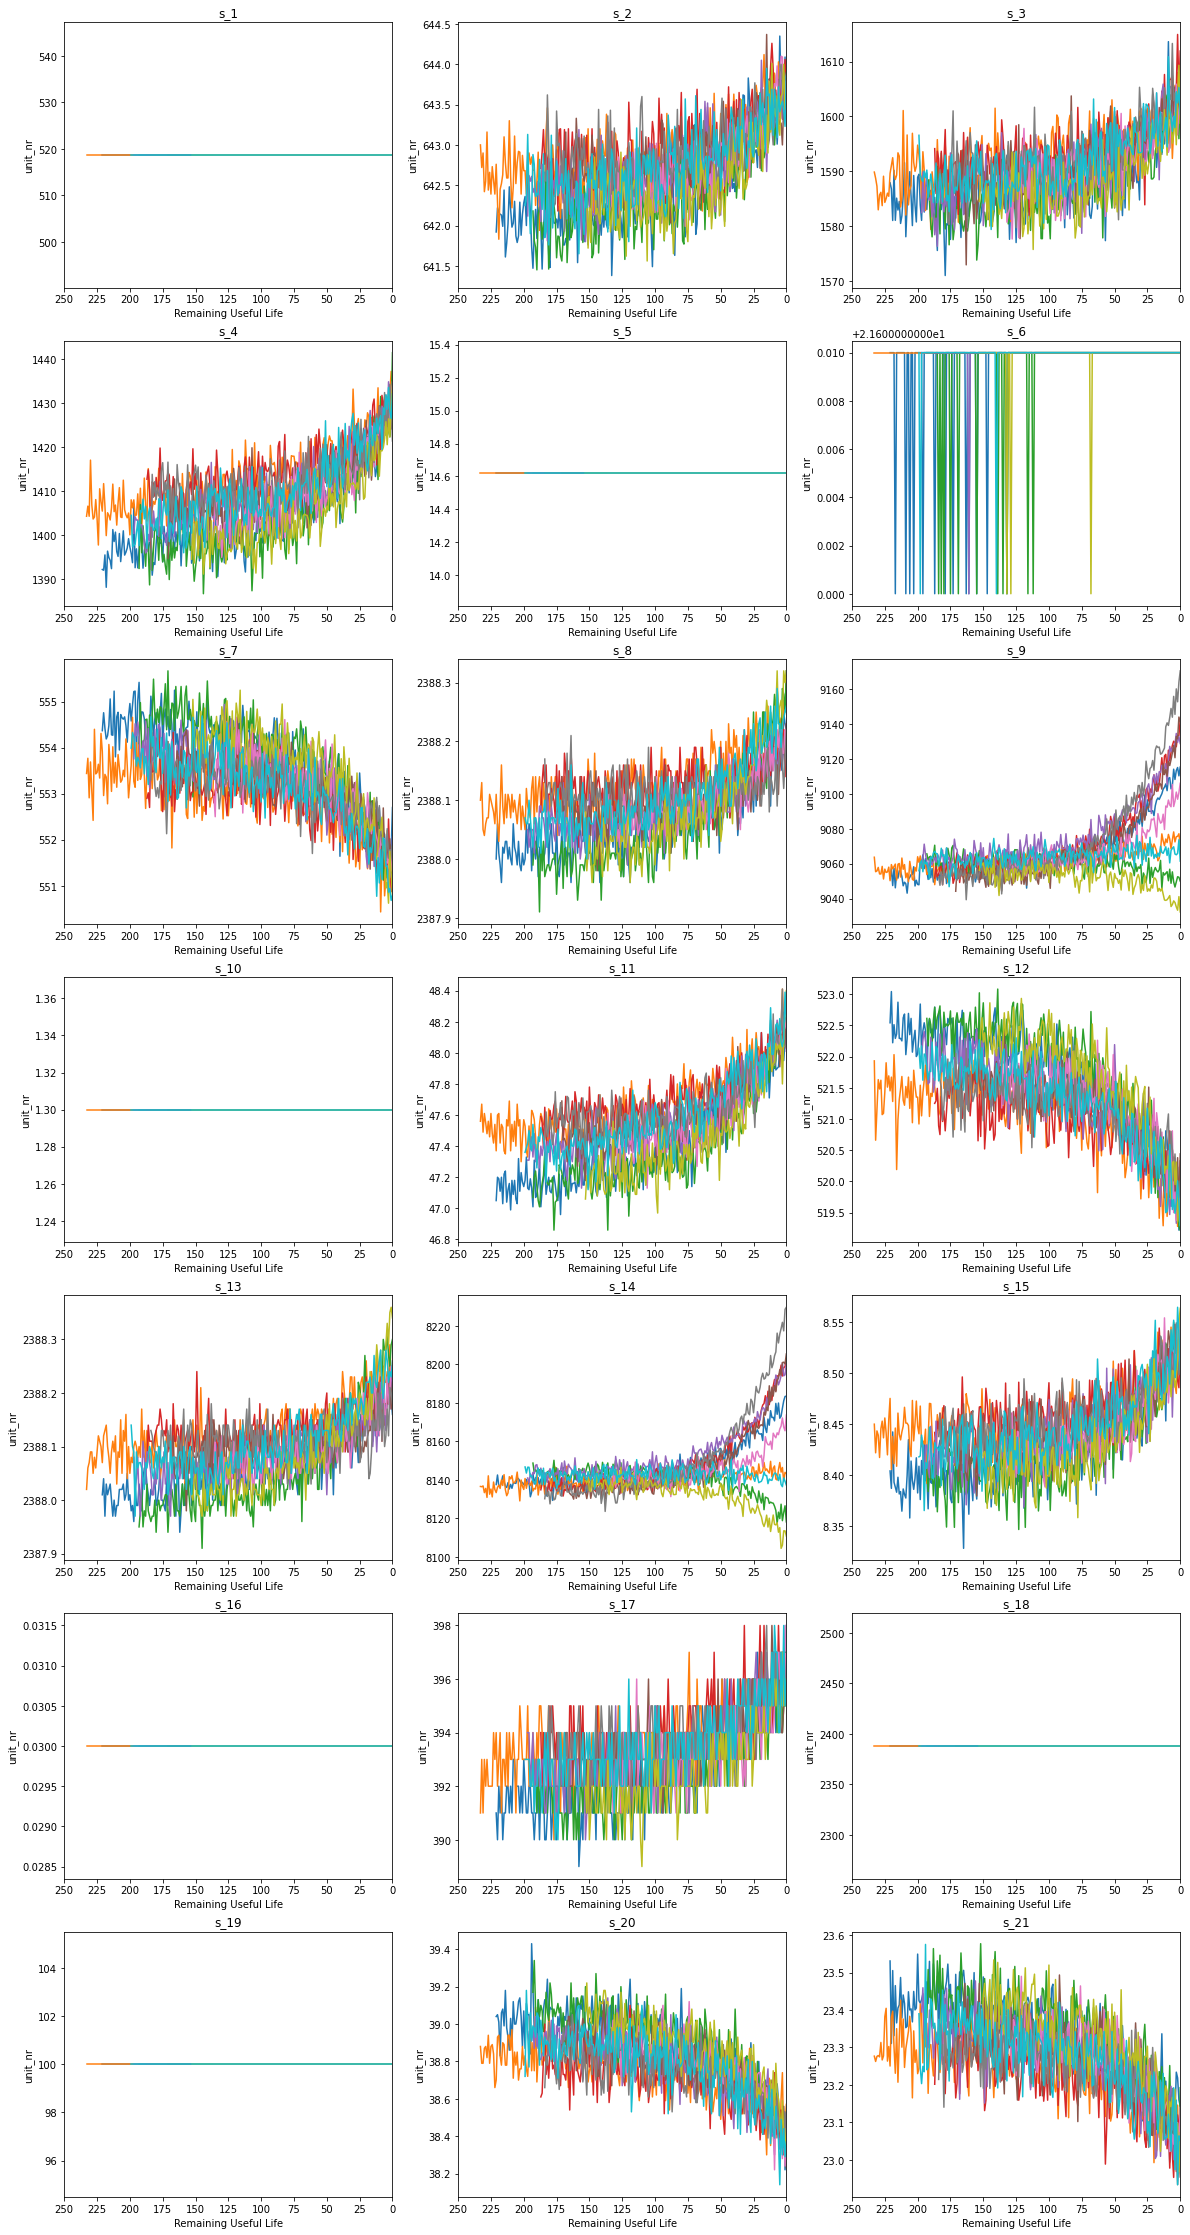

In [11]:
fig, axs = plt.subplots(7, 3, figsize=(20,40))
m = 0
n = 0
for sensor_name in sensor_names:
  plot_sensor(sensor_name, train1, axs[m,n])
  n+=1
  if (n >= 3):
    n=0
    m+=1

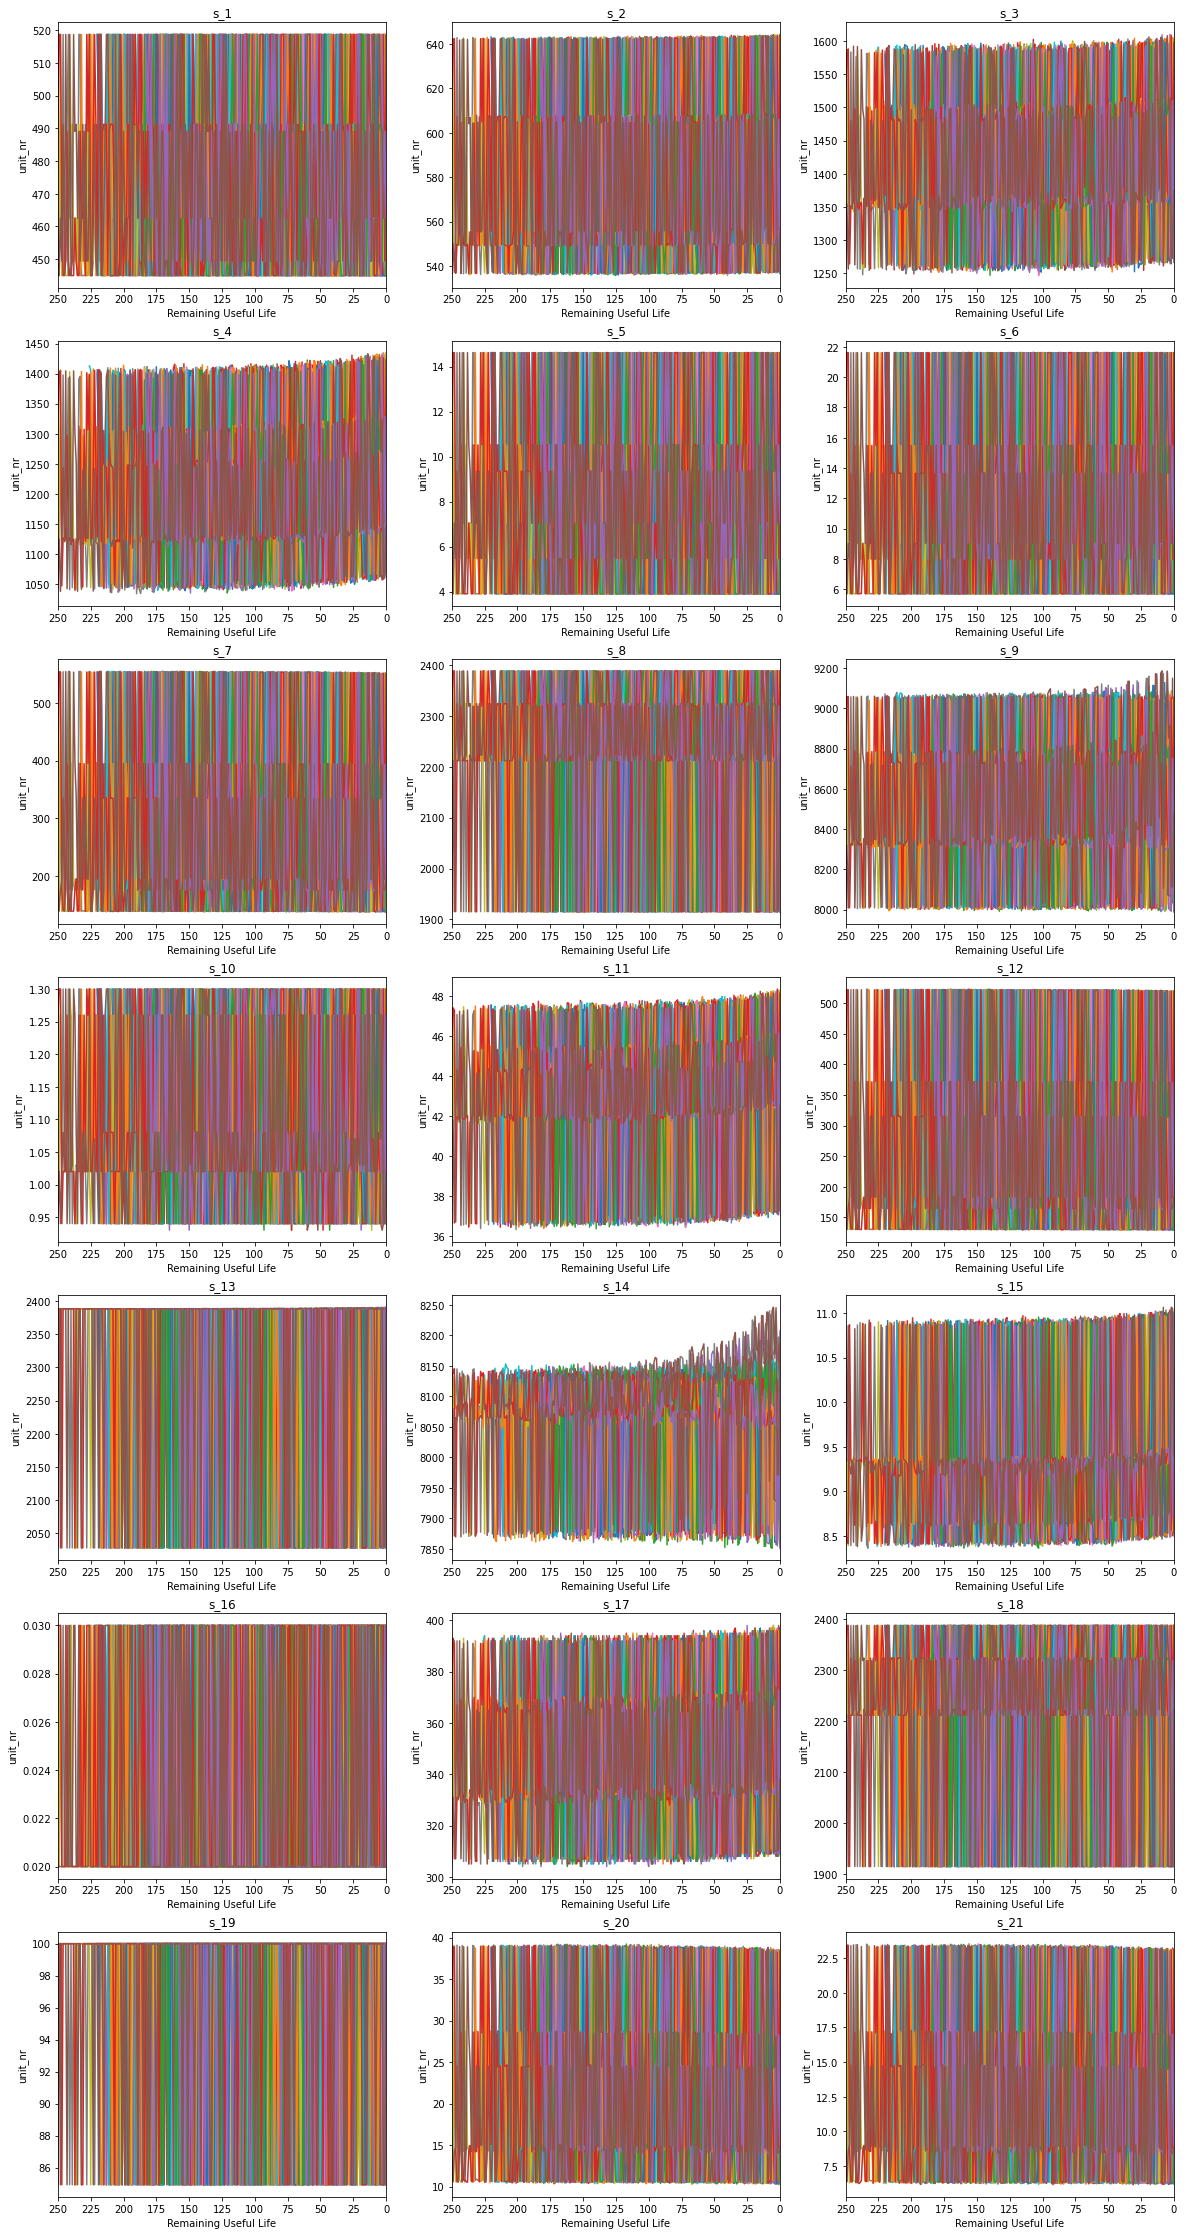

In [12]:
fig, axs = plt.subplots(7, 3, figsize=(20,40))
m = 0
n = 0
for sensor_name in sensor_names:
  plot_sensor(sensor_name, train2, axs[m,n])
  n+=1
  if (n >= 3):
    n=0
    m+=1

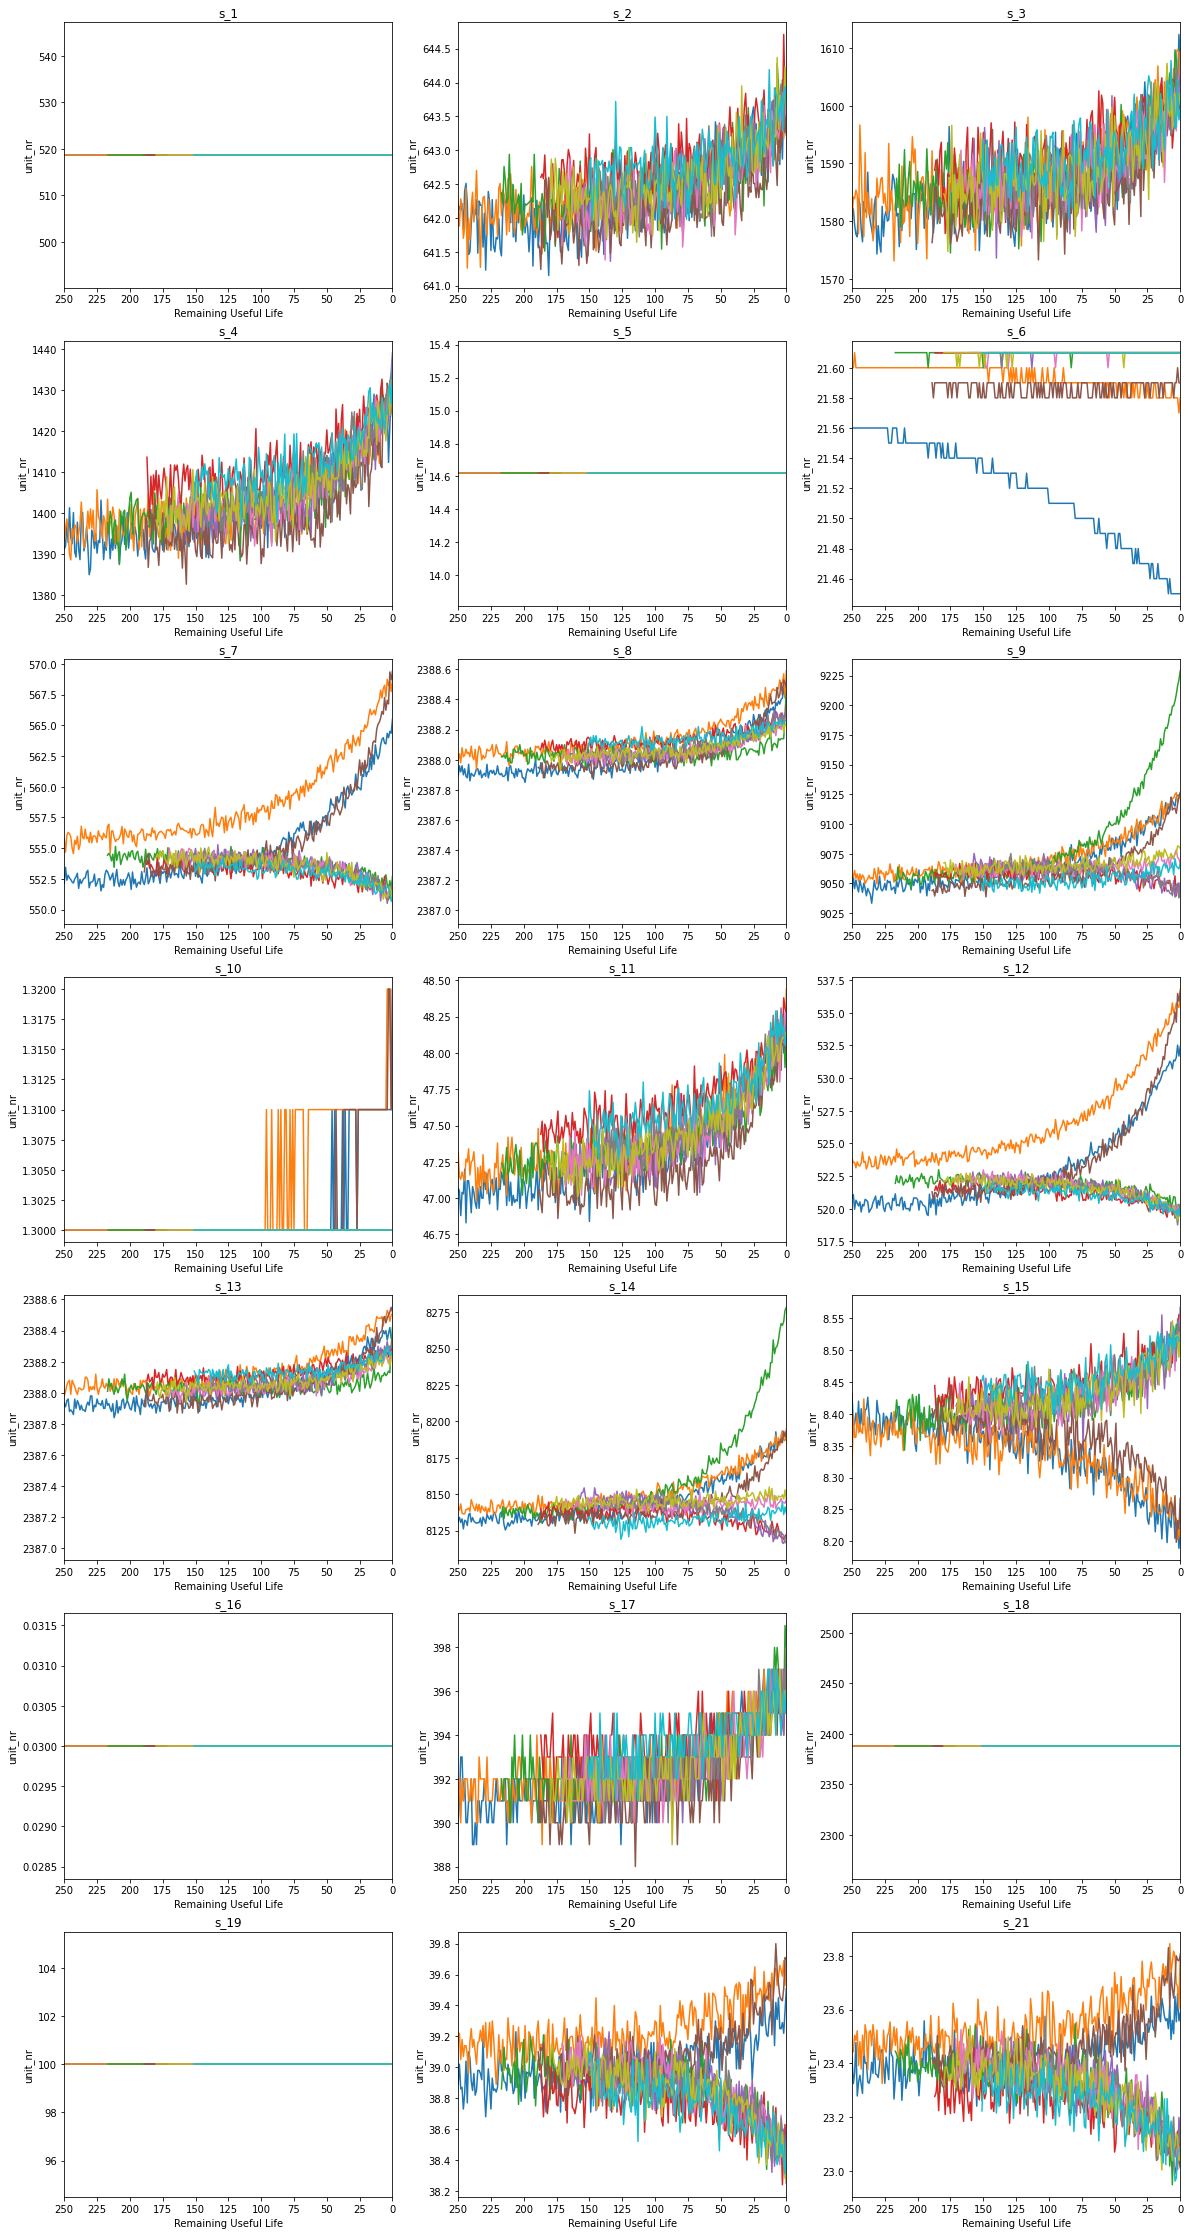

In [13]:
fig, axs = plt.subplots(7, 3, figsize=(20,40))
m = 0
n = 0
for sensor_name in sensor_names:
  plot_sensor(sensor_name, train3, axs[m,n])
  n+=1
  if (n >= 3):
    n=0
    m+=1

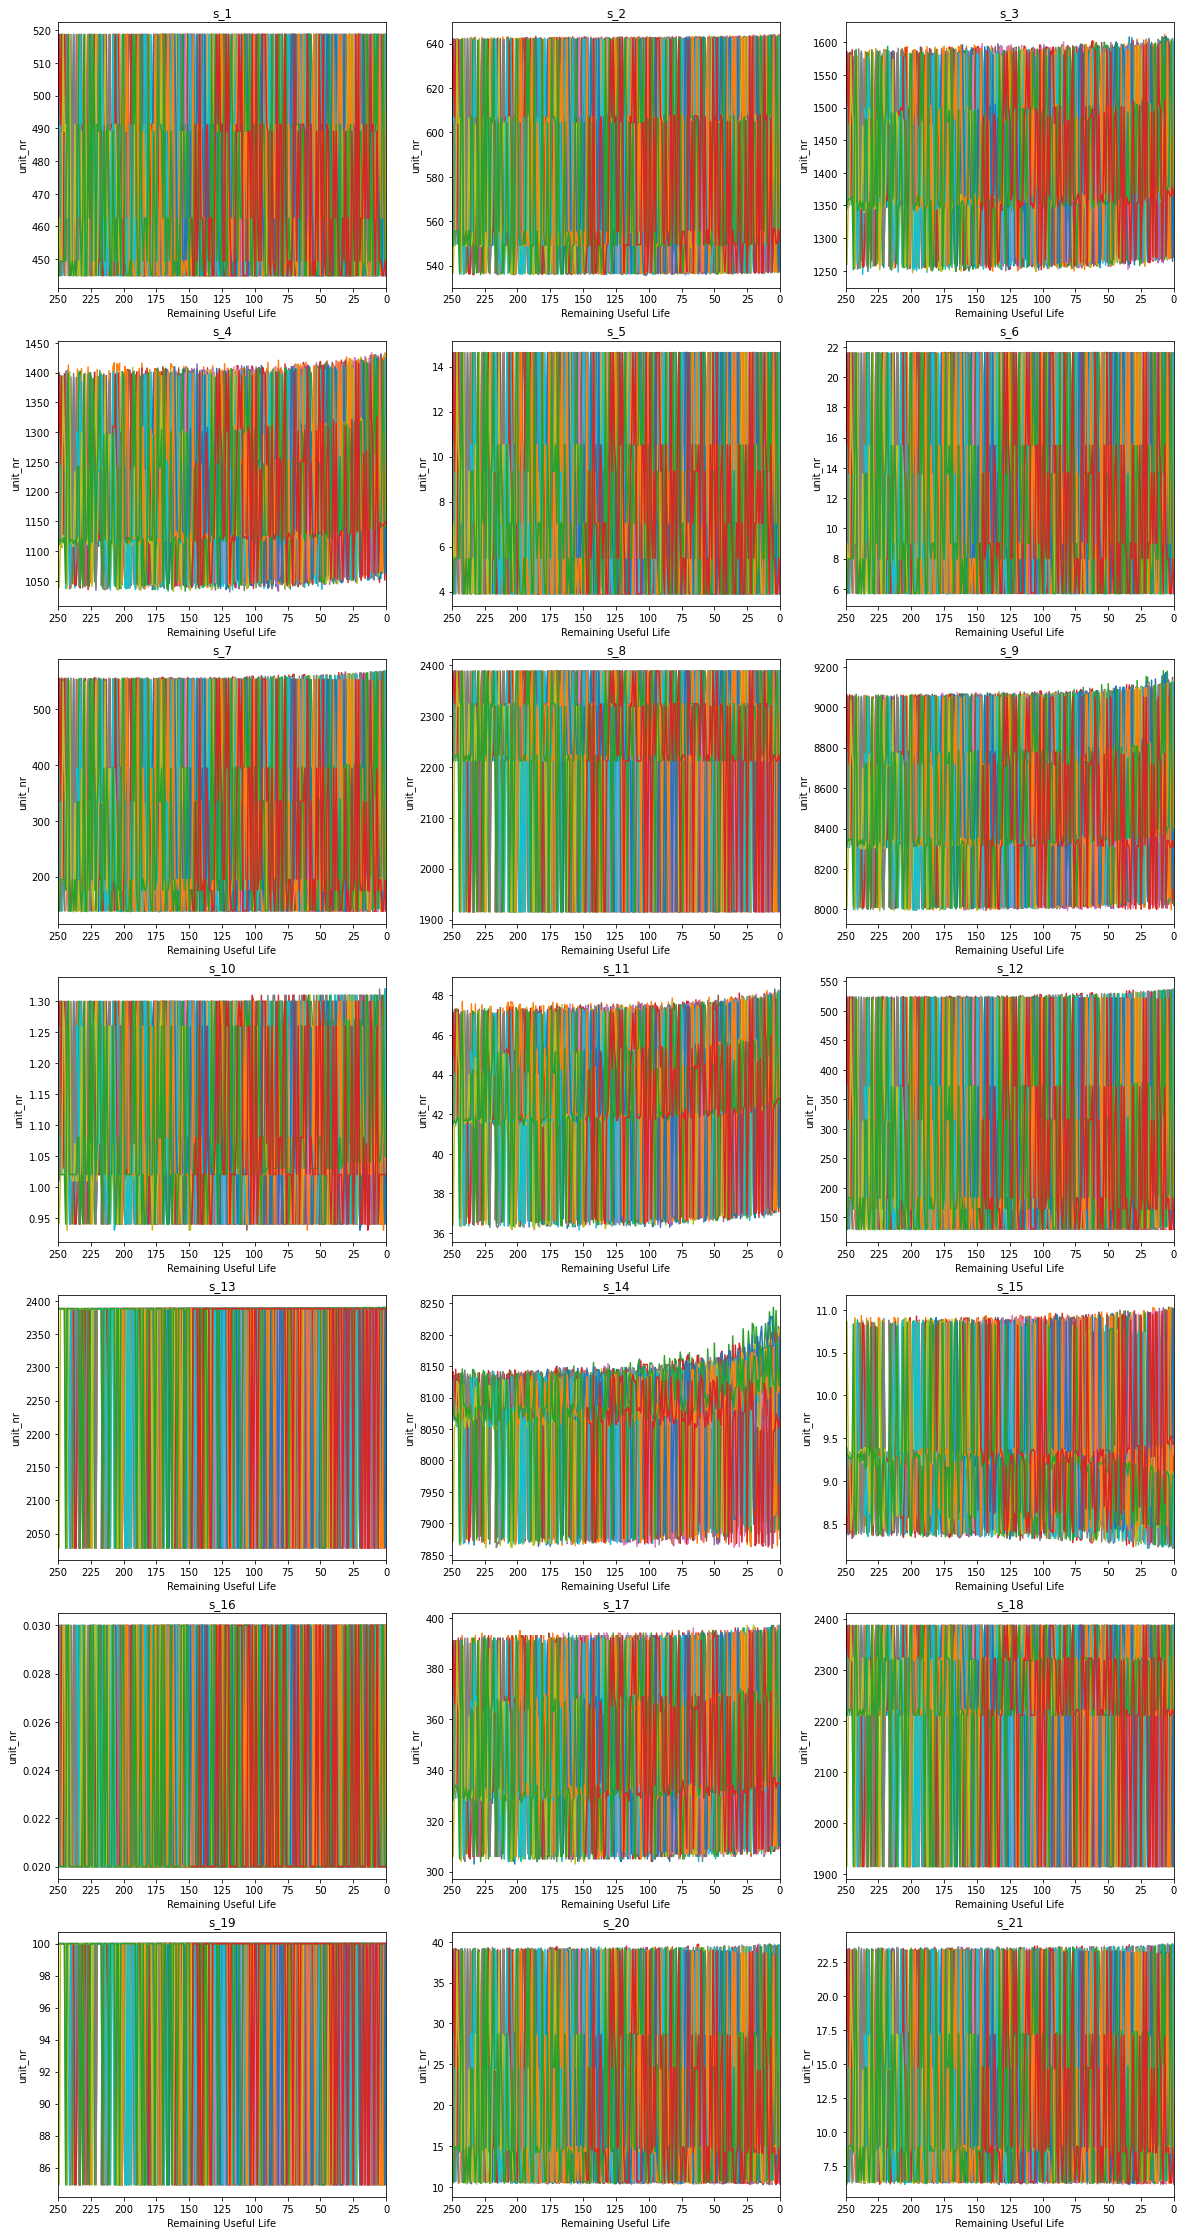

In [14]:
fig, axs = plt.subplots(7, 3, figsize=(20,40))
m = 0
n = 0
for sensor_name in sensor_names:
  plot_sensor(sensor_name, train4, axs[m,n])
  n+=1
  if (n >= 3):
    n=0
    m+=1

## Model

In [142]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

## FD001

### Linear Regression

In [152]:
drop_labels = index_names+setting_names

x_train = train1.drop(drop_labels, axis=1)
y_train = x_train.pop('RUL')

x_test = test1.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [153]:
lm = LinearRegression()
lm.fit(x_train, y_train)

y_hat_train = lm.predict(x_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(x_test)
evaluate(y_test1, y_hat_test)

train set RMSE:44.66280666026599, R2:0.5795500450752352
test set RMSE:31.949774556365636, R2:0.4088794578336493


### Clipping RUL

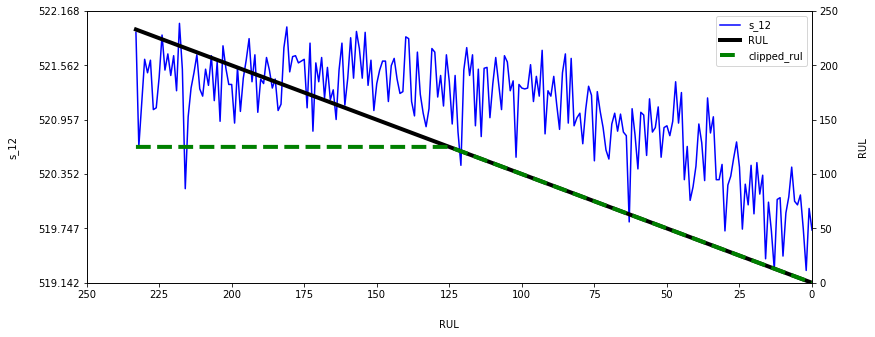

In [154]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot('RUL', 's_12', 'b',
                 data=train1.loc[train1['unit_nr']==20])
plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('s_12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot('RUL', 'RUL', 'k', linewidth=4,
                   data=train1.loc[train1['unit_nr']==20])
rul = train1.loc[train1['unit_nr']==20, 'RUL']
rul_line2 = ax2.plot(rul, rul.where(rul <= 125, 125), '--g', linewidth=4, label='clipped_rul')  # SET LABEL MANUALLY?
ax2.set_ylabel('RUL', labelpad=20)

# code to have equal spacing of y ticks for both axes, so the gridlines allign
# from https://stackoverflow.com/questions/20243683/matplotlib-align-twinx-tick-marks?rq=1
ax2.set_ylim(0, 250)
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))

# code to have a unified legend
# from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = signal+rul_line+rul_line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)

plt.show()

In [155]:
y_train_clipped = y_train.clip(upper=125)

In [156]:
lm = LinearRegression()
lm.fit(x_train, y_train_clipped)  

# predict and evaluate
y_hat_train = lm.predict(x_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(x_test)
evaluate(y_test1, y_hat_test)

train set RMSE:21.46848405566728, R2:0.7346007381093951
test set RMSE:21.894735146490827, R2:0.7223997532095181


### Feature Engineering

In [157]:
x_train.shape

(20631, 21)

In [158]:
sel = SmartCorrelatedSelection(selection_method='variance')
x_new = sel.fit_transform(x_train, y_train)
drop = sel.features_to_drop_

In [159]:
drop_labels = index_names+setting_names+drop
x_train = train1.drop(drop_labels, axis=1)
y_train = x_train.pop('RUL')

x_test = test1.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [160]:
scaler = StandardScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [161]:
# 2nd degree polynomialFeatures of [a, b] becomes [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.fit_transform(X_test_scaled)

print(X_train_scaled.shape)
print(X_train_transformed.shape)

(20631, 17)
(20631, 171)


In [162]:
lm = LinearRegression()
lm.fit(x_train, y_train)

y_hat_train = lm.predict(x_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(x_test)
evaluate(y_test1, y_hat_test)

train set RMSE:45.080158719429065, R2:0.5716555335261215
test set RMSE:31.765358031947567, R2:0.41568374884946957


### Support Vector Regression

In [163]:
svr_f = SVR()
svr_f.fit(X_train_transformed, y_train_clipped)  

y_hat_train = svr_f.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr_f.predict(X_test_transformed)
evaluate(y_test1, y_hat_test)

train set RMSE:20.45077876542062, R2:0.7591666348318469
test set RMSE:20.08431755561452, R2:0.7664098020633604


### Random Forest Regressor

In [164]:
rf = RandomForestRegressor(max_features="sqrt")
rf.fit(X_train_transformed, y_train_clipped)

y_hat_train = rf.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test_transformed)
evaluate(y_test1, y_hat_test)

train set RMSE:7.087705473348393, R2:0.9710726748229346
test set RMSE:18.583389168824937, R2:0.8000182798979147


#### KFold Cross Validation

In [165]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

kf = KFold(10)
for train_index, test_index in kf.split(X_train_transformed):
    # print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = X_train_transformed[train_index], X_train_transformed[test_index]
    y_train, y_test = y_train_clipped[train_index], y_train_clipped[test_index]

    rf.fit(X_train, y_train)
    y_hat_train = rf.predict(X_train)
    y_hat_test = rf.predict(X_test)

In [166]:
y_hat_train = rf.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test_transformed)
evaluate(y_test1, y_hat_test)

train set RMSE:9.113441944214788, R2:0.9521742471096681
test set RMSE:18.476420459602014, R2:0.8023139019877356


## FD002